# Read the DESC truth tables in parquet format

**A large container must be used for this notebook or the kernel will crash.**

**Contact authors:** Jeff Carlin and Melissa Graham <br>
**Container size:** large <br>
**Last verified to run:** 2023-02-15 <br>
**Version:** w_2023_07

## 1.0. Introduction

Jim Chiang has put additional <a href="https://parquet.apache.org/">parquet</a>-format truth tables in `/project` for DP0 delegates:
 - `/project/jchiang/Run2.2i/truth/` contains
   - `SNe/truth_sn_summary_v1-0-0.parquet` (46M)
   - `SNe/truth_sn_variability_v1-0-0.parquet` (247M)
   - `stars/truth_star_summary_v1-0-0.parquet` (211M)
   - `stars/truth_star_variability_v1-0-0.parquet` (5.3G)

These truth tables have been publicly released by the DESC, but they are not part of DP0.2. They contain more detailed information about the simulated supernovae (SNe) and stars that were injected into the DP0.2 dataset. 

> **Warning: these truth tables have not been, and will not be, cross-matched to the DP0.2 DiaObject table nor available via the TAP service like other DP0.2 catalogs.** 

Attempting to use TAP or SQL on these parquet files will fail.
In particular, note that the tutorial notebook "08_Truth_Tables.ipynb" uses the `id_truth_type` column to match between DP0.2 truth catalogs, and that this column is *unique* to the DP0.2 truth catalogs.
It is *not available* in these auxiliary truth data files that come directly from DESC.

This notebook demonstrates the other methods available for users to cross-match their DP0.2 objects of interest with these truth tables.

The **schema** for these tables can be found in the DESC's DC2 Data Release note (<a href="https://arxiv.org/pdf/2101.04855.pdf">arXiv:2101.04855</a>),
in tables B.3 (truth star summary), B.4 (truth SN summary), B.6 (truth star variability), and B.7 (truth SN variability).

> **Warning: the truth star variability file, at 5.3 G, is too large to be read in full and will crash the kernel.**

For the large file of truth star variability, users have the option of the `pyarrow` or `dask` packages for retrieving variability data for a single star, and then converting it into a `pandas` dataframe.
As demonstrated in Section 2, it takes about 15-20 seconds to retrieve the full simulated light curve for a single star. 
Use the truth star variability file with care to avoid crashing the kernel.

The three files that are <250 MB are small enough to be read in full.
The `pandas` package can be used to read the entire table into a dataframe, as demonstrated below.

Rerunning cells multiple times might cause a kernel error in this notebook, given the potentially large data volumes.
If this happens, go to the "Kernel" menu item and choose "Restart kernel and clear all outputs" and try again.
If issues persist, exit the RSP and log back in with a large container.

### 1.1. Import packages.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import time, gc
import pandas as pd
import pyarrow.parquet as pq
from lsst.rsp import get_tap_service, retrieve_query

In [22]:
service = get_tap_service("tap")

## 2.0. Stars

Define the file names of the star truth data.

In [23]:
pfnm_star_sum = '/project/jchiang/Run2.2i/truth/stars/truth_star_summary_v1-0-0.parquet'

### 2.1. Read the full summary table with `pandas`

The star summary file, at 211 M, is small enough to be read in entirely with `pandas`, as done below.

But, if you attempt to use `pd.read_parquet` with the star variability file (5.3 G), the kernel will crash.

In [24]:
result_star_sum = pd.read_parquet(pfnm_star_sum)

**Option** to view the star summary table.

In [25]:
# result_star_sum

### 2.2. Identify a single true star of interest

Use `numpy.unique` to figure out how many different variable star types there are.

In [26]:
unique_models, counts_models = np.unique(result_star_sum['model'], return_counts=True)
for uu in range(len(unique_models)):
    print(uu, unique_models[uu], counts_models[uu])

0 MLT 2361402
1 None 126709
2 applyRRly 211
3 kplr 1744538


As described in the DESC DC2 Data Release Note, these types include:
1. `applyRRly`: periodic variables (RR Lyrae and Cepheids)
2. `MLT`: non-periodic transients/variables such as microlensing events, flaring M-dwarfs, cataclysmic variables, etc.
3. `kplr`: stars with no definitive variability class, whose variability is modeled after Kepler lightcurves
4. `None`: non-variable stars

Use `tx` to index all 211 of the RR Lyrae stars. Print the `id`, `ra`, and `dec` of a random RR Lyrae.

In [27]:
result_star_sum

,id,ra,dec,flux_u,flux_g,flux_r,flux_i,flux_z,flux_y,model,max_stdev_delta_mag,above_threshold,av,rv
0,1568506380,66.100848,-26.937555,5.153635e+00,4.960415e+01,1.580730e+02,3.470435e+02,4.987419e+02,5.986466e+02,MLT,0.0,0,0.130902,3.1
1,1664492176,66.099048,-26.946266,9.245675e-01,8.378922e+00,2.583640e+01,6.260990e+01,9.378958e+01,1.143381e+02,MLT,0.0,0,0.132010,3.1
2,459335937,66.070192,-26.940069,1.569032e+02,1.299442e+03,4.636729e+03,2.360359e+04,5.251571e+04,8.894358e+04,MLT,0.0,0,0.131201,3.1
3,1568506704,66.084465,-26.942259,1.305582e+01,1.183114e+02,3.647971e+02,8.839918e+02,1.324188e+03,1.614285e+03,MLT,0.0,0,0.131838,3.1
4,1568509007,66.077100,-26.953881,1.966530e+01,1.894428e+02,6.040618e+02,1.326789e+03,1.907360e+03,2.289860e+03,MLT,0.0,0,0.133267,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4232855,811836,52.744424,-36.134524,5.076070e+05,1.080536e+06,9.087136e+05,7.449787e+05,6.417327e+05,6.258378e+05,None,0.0,0,0.036837,3.1
4232856,811711,51.714997,-35.380632,1.687590e+06,3.898318e+06,3.951708e+06,3.639226e+06,3.314412e+06,3.255536e+06,None,0.0,0,0.033396,3.1
4232857,812056,52.212314,-37.740603,9.252690e+04,2.024404e+05,1.727427e+05,1.428821e+05,1.257330e+05,1.234560e+05,None,0.0,0,0.051995,3.1
4232858,811996,51.416731,-37.322102,9.341741e+05,2.176235e+06,1.933889e+06,1.648674e+06,1.474439e+06,1.460416e+06,None,0.0,0,0.058935,3.1


In [28]:
np.sum(result_star_sum['above_threshold'][:])

466094

In [29]:
tx = np.where((result_star_sum['model'][:] == 'MLT')) # & (result_star_sum['above_threshold'][:] == 1))
len(tx[0])

2361402

In [30]:
len(result_star_sum)

4232860

In [31]:
tx = np.where(result_star_sum['model'][:] == 'MLT') # & result_star_sum['above_threshold'][:] == 1)
randobj = np.random.choice(tx[0], size=1)
print(result_star_sum['id'][randobj[0]], \
      result_star_sum['ra'][randobj[0]], \
      result_star_sum['dec'][randobj[0]])
# del tx, ri

31102100049 65.1609684 -35.1200114


In [32]:
umag = (result_star_sum.flux_u.values*u.nJy).to(u.ABmag)
gmag = (result_star_sum.flux_g.values*u.nJy).to(u.ABmag)
rmag = (result_star_sum.flux_r.values*u.nJy).to(u.ABmag)
imag = (result_star_sum.flux_i.values*u.nJy).to(u.ABmag)
zmag = (result_star_sum.flux_z.values*u.nJy).to(u.ABmag)
ymag = (result_star_sum.flux_y.values*u.nJy).to(u.ABmag)

gr = gmag-rmag
gi = gmag-imag
ri = rmag-imag
iz = imag-zmag
zy = zmag-ymag

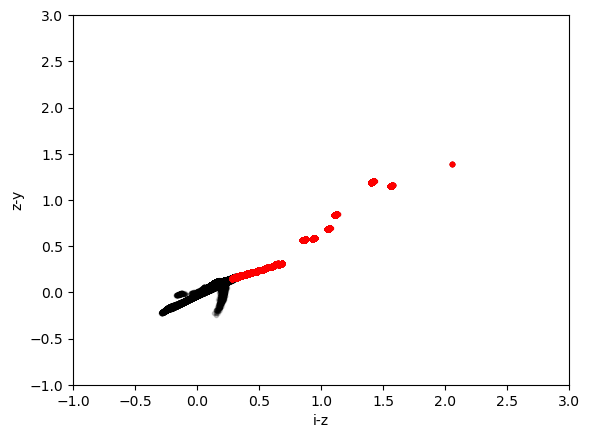

In [33]:
plt.plot(iz, zy, 'k.', alpha=0.1)
plt.plot(iz[tx], zy[tx], 'r.', alpha=0.5)
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.xlabel('i-z')
plt.ylabel('z-y')
plt.show()

In [46]:
redstars = np.where(iz[tx[0]].value > 0.8)
len(redstars[0])

431143

(array([2.0000e+00, 5.0000e+00, 1.4000e+01, 2.0000e+01, 4.1000e+01,
        9.3000e+01, 1.7800e+02, 3.2400e+02, 5.1100e+02, 8.2700e+02,
        1.3430e+03, 1.8760e+03, 2.7270e+03, 3.7330e+03, 5.1480e+03,
        7.2380e+03, 9.6440e+03, 1.3164e+04, 1.7550e+04, 2.2341e+04,
        2.7089e+04, 3.1518e+04, 3.5029e+04, 3.8267e+04, 4.2809e+04,
        4.9414e+04, 5.7134e+04, 4.8928e+04, 1.3734e+04, 4.4200e+02]),
 array([ 5.79327297,  6.54096937,  7.28866577,  8.03636265,  8.78405857,
         9.53175545, 10.27945137, 11.02714825, 11.77484512, 12.52254105,
        13.27023792, 14.01793385, 14.76563072, 15.51332664, 16.26102257,
        17.0087204 , 17.75641632, 18.50411224, 19.25181007, 19.999506  ,
        20.74720192, 21.49489784, 22.24259567, 22.9902916 , 23.73798752,
        24.48568535, 25.23338127, 25.98107719, 26.72877312, 27.47647095,
        28.22416687]),
 <BarContainer object of 30 artists>)

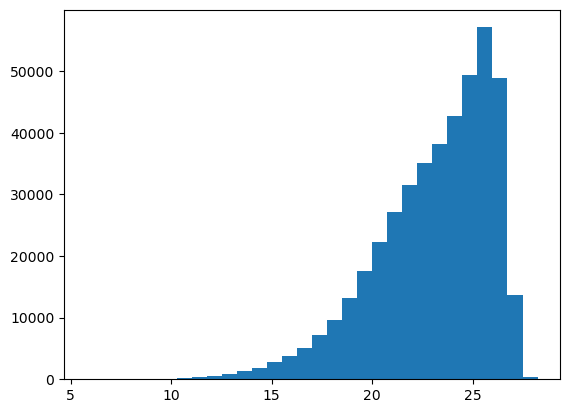

In [49]:
plt.hist(imag[redstars].value, bins=30)

In [34]:
my_star_id = result_star_sum['id'][randobj[0]]
my_star_ra = result_star_sum['ra'][randobj[0]]
my_star_dec = result_star_sum['dec'][randobj[0]]

In [35]:
print(my_star_id, my_star_ra, my_star_dec)

31102100049 65.1609684 -35.1200114


If all we had was an RA and Dec that we got by, for example, identifying a `DiaObject` that we thought might be an RR Lyrae, we could find the `id` in the star summary table.

For this example, use RA = 72.5850633 and Dec = -44.6386746.

In [31]:
# my_star_ra = 72.5850633
# my_star_dec = -44.6386746

In [32]:
tx = np.where((np.abs(result_star_sum['ra'] - my_star_ra) < 2.0/3600.)
              & (np.abs(result_star_sum['dec'] - my_star_dec) < 2.0/3600.))[0]
if(len(tx) == 1):
    print('Unique match identified within 2 arcseconds.')
    print(result_star_sum['id'][tx[0]], \
          result_star_sum['ra'][tx[0]], \
          result_star_sum['dec'][tx[0]])
else:
    print('Number of matches: ', len(tx))
del tx

Unique match identified within 2 arcseconds.
31500431204 57.7696272 -33.5449145


In [39]:
results = service.search("SELECT coord_ra, coord_dec, objectId, g_psfFlux, r_psfFlux, i_psfFlux, "\
                         "detect_isPrimary, g_extendedness, r_extendedness, i_extendedness "\
                         "FROM dp02_dc2_catalogs.Object "\
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS',"+str(my_star_ra)+", "+str(my_star_dec)+", 0.0005)) = 1 "\
                         "AND detect_isPrimary>0.5", maxrec=100000)
objs = results.to_table()


In [40]:
objs

coord_ra,coord_dec,objectId,g_psfFlux,r_psfFlux,i_psfFlux,detect_isPrimary,g_extendedness,r_extendedness,i_extendedness
deg,deg,,nJy,nJy,nJy,,,,
float64,float64,int64,float64,float64,float64,bool,float64,float64,float64
65.1609695,-35.1200118,1737087634397768515,1106.5635754,3513.2820496,8357.2262517,True,1.0,1.0,1.0


In [50]:
sel_objid = objs[0]['objectId']

In [51]:
# Define the query
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "visinfo.ccdVisitId, visinfo.band, visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "


In [52]:
results = service.search(query)
srcs = results.to_table()

srcs['psfMag'] = (srcs['psfFlux'].value*u.nJy).to(u.ABmag)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [53]:
srcs

band,ccdVisitId,coord_ra,coord_dec,objectId,psfFlux,psfFluxErr,ccdVisitId2,band2,expMidptMJD,zeroPoint,psfMag
,,deg,deg,,nJy,nJy,,,d,mag,mag(AB)
object,int64,float64,float64,int64,float64,float64,int64,object,float64,float32,float64
u,235785083,65.1609695,-35.1200118,1737087634397768515,-155.121196,259.4543556,235785083,u,59905.0642402,30.4596,nan
u,1204987138,65.1609695,-35.1200118,1737087634397768515,70.7722283,223.2115095,1204987138,u,61351.1109692,30.4739,26.77534282548597
u,885376079,65.1609695,-35.1200118,1737087634397768515,139.7512896,212.0562329,885376079,u,60878.4139852,30.4748,26.036610439577373
u,466760160,65.1609695,-35.1200118,1737087634397768515,538.6032458,286.9051641,466760160,u,60261.0952472,30.455,24.571827584288698
u,962484004,65.1609695,-35.1200118,1737087634397768515,-118.5802601,238.9124291,962484004,u,60996.1048492,30.4656,nan
u,963912167,65.1609695,-35.1200118,1737087634397768515,10.3301839,207.5420295,963912167,u,60998.0744062,30.4773,28.864729867535814
u,418193010,65.1609695,-35.1200118,1737087634397768515,-233.4443183,172.5044836,418193010,u,60176.3937672,30.4809,nan
u,235062077,65.1609695,-35.1200118,1737087634397768515,282.1040755,236.8013558,235062077,u,59904.0762212,30.4699,25.273976599088932


In [55]:
picku = (srcs['band'] == 'u')
pickg = (srcs['band'] == 'g')
pickr = (srcs['band'] == 'r')
picki = (srcs['band'] == 'i')
pickz = (srcs['band'] == 'z')
picky = (srcs['band'] == 'y')

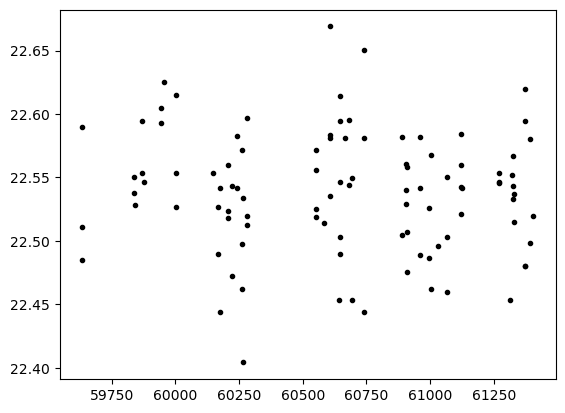

In [56]:
plt.plot(srcs[pickr]['expMidptMJD'], srcs[pickr]['psfMag'], 'k.')
plt.show()

Clean up.

In [ ]:
del result_star_sum, my_star_ra, my_star_dec
gc.collect()

### 2.3. Use `pyarrow` to retrieve the true light curve

Use `pyarrow` to retrieve the  true variability (true light curve) for this one RR Lyrae of interest, with `id` = 836896.

Read the parquet table and only retrieve rows where `id` = 836896. This takes about 10 seconds.

In [ ]:
result = pq.read_table(pfnm_star_var, use_threads=False,
                       filters=[('id', '==', my_star_id)])

Convert the result ot a pandas dataframe, `df`. This takes <1 second.

In [35]:
df = result.to_pandas()

**Option** to show the dataframe.

In [36]:
df

,id,obsHistID,MJD,bandpass,delta_flux


Plot the g, r, and i-band `delta_flux` values.

In [ ]:
gx = df['bandpass'][:] == 'g'
rx = df['bandpass'][:] == 'r'
ix = df['bandpass'][:] == 'i'
plt.plot(df['MJD'][gx], df['delta_flux'][gx], \
         'o', ms=3, mew=0, alpha=0.3, color='darkgreen')
plt.plot(df['MJD'][rx], df['delta_flux'][rx], \
         'o', ms=3, mew=0, alpha=0.3, color='darkorange')
plt.plot(df['MJD'][ix], df['delta_flux'][ix], \
         'o', ms=3, mew=0, alpha=0.3, color='black')
plt.xlabel('MJD (days)')
plt.ylabel('delta$\_$flux (nJy)')
plt.show()
del gx, rx, ix

In [ ]:
del result, df
gc.collect()

### 2.4. Use `dask` to retrieve the true light curve

Use `dask` to retrieve the  true variability (true light curve) for this one RR Lyrae of interest, with `id` = 836896.

**Option** to read the parquet file and view what `dd.read_parquet` returns. Note that it is the structure of the dataframe, NOT a dataframe filled with values.

In [ ]:
# result = dd.read_parquet(pfnm_star_var)

In [ ]:
# result

In [ ]:
# del result

Read the parquet table and only retrieve rows where `id` = 836896. This takes <1 second.

In [ ]:
result = dd.read_parquet(pfnm_star_var, filters = [('id', '==', 836896)])

Convert the result into a `pandas` dataframe. This takes up to 15 seconds.

In [ ]:
df = result.compute()

**Option** to show the `pandas` dataframe.

In [ ]:
# df

Plot the g, r, and i-band `delta_flux` values.

In [ ]:
gx = df['bandpass'][:] == 'g'
rx = df['bandpass'][:] == 'r'
ix = df['bandpass'][:] == 'i'
plt.plot(df['MJD'][gx], df['delta_flux'][gx], \
         'o', ms=3, mew=0, alpha=0.3, color='darkgreen')
plt.plot(df['MJD'][rx], df['delta_flux'][rx], \
         'o', ms=3, mew=0, alpha=0.3, color='darkorange')
plt.plot(df['MJD'][ix], df['delta_flux'][ix], \
         'o', ms=3, mew=0, alpha=0.3, color='black')
plt.xlabel('MJD (days)')
plt.ylabel('delta$\_$flux (nJy)')
plt.show()
del gx, rx, ix

In [ ]:
del result, df
gc.collect()